# ODE → DeepONet Dataset Generator (SciPy adaptive RK)

This notebook uses **SciPy's adaptive ODE solvers** (`solve_ivp`) to generate DeepONet-style datasets.

**Default system:**  
\[ \frac{dv}{dx} = u(x), \quad v(0)=0 \]  
(*i.e.*, the antiderivative operator).

**Precision reporting:** we solve once at a **moderate tolerance** and once at a **tight tolerance** and report errors between the two on the evaluation grid (mean / max / RMSE).

**Output `.npz` format (aligned with your loader):**
- `X[0]`: `(N_samples, in_size_branch)` — discretized input functions
- `X[1]`: `(N_grid, 1)` — shared query grid
- `y`: `(N_samples, N_grid)` — solutions on the grid

Defaults reproduce shapes **`((150, 100), (100, 1), (150, 100))`**, but you can change them below.

Use **`spit=True/False`** to choose train/test split or a single file.

In [6]:

# Optional: uncomment to install SciPy if needed
# %pip install -q scipy

In [7]:
# %pip install -q scipy  # se non hai SciPy

import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Literal, Callable
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import os
os.environ["MKL_NUM_THREADS"] = "8"    # adjust to your CPU cores
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"


# ------------------ Configurazione ------------------
seed = 123

# Dimensioni (default: ((150, 100), (100, 1), (150, 100)))
N_samples      = 150*10       # -> X[0].shape[0], y.shape[0]
in_size_branch = 100*10       # -> X[0].shape[1]
N_grid         = in_size_branch       # -> X[1].shape[0], y.shape[1] Aligned Dataset
x_min, x_max   = 0.0, 1.0

# File / split (usa 'spit' come richiesto)
spit = True                # True: train/test  |  False: singolo file
val_fraction = 0.1   # 10% validation (se spit=True)
test_fraction  = 0.2 # 20% test (se spit=True)
val_fname    = "antiderivative_aligned_val.npz"
train_fname    = "antiderivative_aligned_train.npz"
test_fname     = "antiderivative_aligned_test.npz"
single_fname   = "antiderivative_aligned_data.npz"

# ----- GRF (GP) -----
# Come nel .py e in molti demo DeepONet: kernel RBF con length_scale ~ 0.2
kernel: Literal["RBF","Matern12","Matern32","Matern52"] = "RBF"
length_scale = (0.00001, 0.3) #0.2     # ℓ
sigma        = (0.5, 20.0) #1.0     # varianza marginale di u(x)
N_gp         = 1000    # griglia fine per campionare il GP
interp_kind  = "cubic" # interpolazione di u(x) (cubic come nel .py)

# Solver & stima precisione (run "moderato" vs "stretto")
method_lo, rtol_lo, atol_lo = "RK45",  1e-6,  1e-9
method_hi, rtol_hi, atol_hi = "DOP853",1e-10, 1e-13

np.random.seed(seed)
print(f"N_samples={N_samples}, in_size_branch={in_size_branch}, N_grid={N_grid}, spit={spit}")
print(f"GRF: {kernel}, ℓ={length_scale}, σ={sigma}, N_gp={N_gp}, interp='{interp_kind}'")


N_samples=1500, in_size_branch=1000, N_grid=1000, spit=True
GRF: RBF, ℓ=(1e-05, 0.3), σ=(0.5, 20.0), N_gp=1000, interp='cubic'


In [8]:
def _pairwise_sqdist(x: np.ndarray, y: Optional[np.ndarray]=None) -> np.ndarray:
    y = x if y is None else y
    x = x[:, None]; y = y[None, :]
    return (x - y) ** 2

def kernel_matrix_1d(x: np.ndarray, ell: float, sigma: float, kind: str) -> np.ndarray:
    d2 = _pairwise_sqdist(x)
    if kind == "RBF":
        K = (sigma**2) * np.exp(-0.5 * d2 / (ell**2 + 1e-12))
    elif kind == "Matern12":  # ν=1/2 (esponenziale)
        d = np.sqrt(d2 + 1e-12); K = (sigma**2) * np.exp(-d / (ell + 1e-12))
    elif kind == "Matern32":  # ν=3/2
        d = np.sqrt(d2 + 1e-12); r = np.sqrt(3) * d / (ell + 1e-12)
        K = (sigma**2) * (1 + r) * np.exp(-r)
    elif kind == "Matern52":  # ν=5/2
        d = np.sqrt(d2 + 1e-12); r = np.sqrt(5) * d / (ell + 1e-12)
        K = (sigma**2) * (1 + r + r*r/3.0) * np.exp(-r)
    else:
        raise ValueError(f"Kernel sconosciuto: {kind}")
    return K

class GRFSampler1D:
    """Precompute Cholesky su griglia fine per campionare rapidamente il GP."""
    def __init__(self, x_grid: np.ndarray, ell: float, sigma: float, kind: str="RBF"):
        K = kernel_matrix_1d(x_grid, ell, sigma, kind)
        K.flat[::K.shape[0]+1] += 1e-8  # jitter numerico
        self.L = np.linalg.cholesky(K)
        self.x_grid = x_grid
    def sample(self, rng: np.random.RandomState) -> np.ndarray:
        z = rng.randn(self.x_grid.shape[0])
        return self.L @ z  # GP a media zero


In [9]:
def rhs_from_interpolant(u_interp: Callable[[np.ndarray], np.ndarray]) -> Callable[[float, np.ndarray], np.ndarray]:
    # dv/dx = u(x), v(0)=0  → v(x) = ∫ u
    def f(x: float, v: np.ndarray) -> np.ndarray:
        return np.array([float(u_interp(np.array([x]))[0])])
    return f

def solve_on_grid(f: Callable, y0: float, a: float, b: float, eval_x: np.ndarray,
                  method: str, rtol: float, atol: float):
    sol = solve_ivp(fun=f, t_span=(a, b), y0=[y0], method=method, t_eval=eval_x,
                    rtol=rtol, atol=atol)
    if not sol.success:
        raise RuntimeError(f"solve_ivp failed: {sol.message}")
    return sol.y[0]  # (len(eval_x),)

def precision_against_tight(f: Callable, y0: float, a: float, b: float, eval_x: np.ndarray,
                            method_lo: str, rtol_lo: float, atol_lo: float,
                            method_hi: str, rtol_hi: float, atol_hi: float):
    y_lo = solve_on_grid(f, y0, a, b, eval_x, method_lo, rtol_lo, atol_lo)
    y_hi = solve_on_grid(f, y0, a, b, eval_x, method_hi, rtol_hi, atol_hi)
    err = np.abs(y_hi - y_lo)
    stats = {
        "err_mean": float(np.mean(err)),
        "err_max":  float(np.max(err)),
        "err_rmse": float(np.sqrt(np.mean(err**2))),
    }
    return y_hi, y_lo, stats

In [49]:
#with progress bar (GPU version)
# ===== GPU-accelerated dataset generator with tqdm + robust Cholesky =====
import numpy as np
import torch
from tqdm import tqdm

def build_dataset_grf_gpu(
    N_samples: int,
    in_size_branch: int,
    N_grid: int,
    x_min: float,
    x_max: float,
    *,
    length_scale_edges,
    sigma_edges,
    sigma_space: str = "log",
    kernel: str = "RBF",        # "RBF" | "Matern12" | "Matern32" | "Matern52"
    N_gp: int = 1000,
    # 'interp_kind' & ODE settings are ignored on GPU version (we integrate via trapz)
    interp_kind: str = "cubic",
    method_lo: str = "RK45", rtol_lo: float = 1e-6,  atol_lo: float = 1e-9,
    method_hi: str = "DOP853", rtol_hi: float = 1e-10, atol_hi: float = 1e-13,
    seed: int = 123,
    normalize: str = "maxint",
    return_meta: bool = False,
    batch_size: int = 64,
    device: str = "cuda",
    dtype: torch.dtype = torch.float64,     # float64 improves PD stability
    base_jitter: float = 1e-8,              # starting jitter (scaled adaptively)
    max_cholesky_tries: int = 6
):
    """
    GPU implementation:
      - Draw GP on fine grid (gp_x) via batched Cholesky.
      - Interpolate to branch/trunk grids on GPU.
      - Antiderivative via cumulative trapezoid on trunk_x (v(x_min)=0).
      - Adaptive jitter ensures PD; eigen fallback if needed.
    """
    # ---- device & CUDA check ----
    if device.startswith("cuda") and not torch.cuda.is_available():
        raise RuntimeError("CUDA not available. Set device='cpu' or enable a GPU.")
    dev = torch.device(device)

    # ---- grids on GPU ----
    branch_x = torch.linspace(x_min, x_max, in_size_branch, device=dev, dtype=dtype)
    trunk_x  = torch.linspace(x_min, x_max, N_grid,        device=dev, dtype=dtype)
    gp_x     = torch.linspace(x_min, x_max, N_gp,          device=dev, dtype=dtype)

    # Precompute squared distances on fine grid
    gx = gp_x.view(-1, 1)
    d2 = (gx - gx.T).pow(2)   # (N_gp, N_gp)

    # ---- kernel builders (vectorized over batch) ----
    def build_kernel(ell_b, sig_b):
        # ell_b, sig_b: (B,)
        e = ell_b.view(-1, 1, 1)
        s = sig_b.view(-1, 1, 1)
        if kernel == "RBF":
            K = (s**2) * torch.exp(-0.5 * d2.unsqueeze(0) / (e**2 + 1e-16))
        else:
            d = torch.sqrt(d2 + 1e-16).unsqueeze(0) / (e + 1e-16)  # (B,N,N)
            if kernel == "Matern12":
                K = (s**2) * torch.exp(-d)
            elif kernel == "Matern32":
                r = (np.sqrt(3.0)) * d
                K = (s**2) * (1.0 + r) * torch.exp(-r)
            elif kernel == "Matern52":
                r = (np.sqrt(5.0)) * d
                K = (s**2) * (1.0 + r + (r*r)/3.0) * torch.exp(-r)
            else:
                raise ValueError(f"Unknown kernel: {kernel}")
        # Enforce symmetry numerically
        K = 0.5 * (K + K.transpose(-1, -2))
        return K

    # ---- cumulative trapezoid on GPU ----
    def cumtrapz_batch(y, x):
        # y: (B,M), x: (M,)
        dx = x[1:] - x[:-1]                       # (M-1,)
        mid = 0.5 * (y[:, 1:] + y[:, :-1]) * dx  # (B, M-1)
        zero = torch.zeros((y.size(0), 1), device=y.device, dtype=y.dtype)
        return torch.cat([zero, mid.cumsum(dim=1)], dim=1)

    # ---- robust batched Cholesky with adaptive jitter; eigen fallback per failed element ----
    def robust_cholesky(K):
        # K: (B,N,N)
        B, N, _ = K.shape
        # Start with small jitter proportional to diagonal scale
        diag = torch.diagonal(K, dim1=-2, dim2=-1)  # (B,N)
        scale = diag.mean(dim=1, keepdim=True)      # (B,1)
        scale = torch.clamp(scale, min=torch.finfo(K.dtype).eps)
        L = None
        info = None

        K_try = K.clone()
        for t in range(max_cholesky_tries):
            jitter = (base_jitter * (10.0 ** t)) * scale
            Kj = K_try.clone()
            Kj[:, torch.arange(N), torch.arange(N)] += jitter  # add jitter to diag per batch element
            L_try, info = torch.linalg.cholesky_ex(Kj)         # info=0 means success
            if (info == 0).all():
                return L_try
            # For failures, update only those slices with larger jitter next loop
            failed = (info != 0).nonzero(as_tuple=False).flatten()
            if t == max_cholesky_tries - 1:
                # Fall back to eigen fix for the failed ones
                L_fix = L_try
                for b in failed.tolist():
                    S = 0.5 * (K[b] + K[b].T)  # symmetrize
                    evals, Q = torch.linalg.eigh(S)
                    # Clip eigenvalues to a small positive floor relative to mean diag
                    floor = (base_jitter * 100.0) * scale[b, 0]
                    evals_clipped = torch.clamp(evals, min=floor)
                    Lb = Q @ torch.diag(torch.sqrt(evals_clipped))  # S ≈ L L^T
                    L_fix[b] = Lb
                return L_fix
            # else loop again with bigger jitter
            K_try = Kj

    # ---- deterministic parameter placement (CPU) ----
    ell_edges = np.asarray(length_scale_edges, dtype=float)
    sig_edges = np.asarray(sigma_edges, dtype=float)
    n_ell = len(ell_edges) - 1
    n_sig = len(sig_edges) - 1
    if n_ell <= 0 or n_sig <= 0:
        raise ValueError("length_scale_edges and sigma_edges must have at least 2 entries (1 bin).")

    num_cells = n_ell * n_sig
    if N_samples < num_cells:
        raise ValueError(f"N_samples={N_samples} is less than the number of grid cells={num_cells}.")
    base = N_samples // num_cells
    rem  = N_samples % num_cells

    params = []
    for ie in range(n_ell):
        lo_e, hi_e = ell_edges[ie], ell_edges[ie+1]
        for js in range(n_sig):
            lo_s, hi_s = sig_edges[js], sig_edges[js+1]
            n_cell = base + (1 if rem > 0 else 0)
            if rem > 0:
                rem -= 1
            pos = (np.arange(n_cell) + 0.5) / max(1, n_cell)
            ells = lo_e + (hi_e - lo_e) * pos
            if sigma_space == "log":
                if lo_s <= 0 or hi_s <= 0:
                    raise ValueError("Geometric interpolation requires positive sigma edges.")
                sigs = np.exp(np.log(lo_s) + (np.log(hi_s) - np.log(lo_s)) * pos)
            elif sigma_space == "linear":
                sigs = lo_s + (hi_s - lo_s) * pos
            else:
                raise ValueError("sigma_space must be 'log' or 'linear'.")
            for e, s in zip(ells, sigs):
                if len(params) < N_samples:
                    params.append((float(e), float(s)))
    assert len(params) == N_samples

    # ---- allocate outputs (NumPy) ----
    branch_inputs = np.zeros((N_samples, in_size_branch), dtype=np.float64)
    outputs       = np.zeros((N_samples, N_grid),        dtype=np.float64)
    ell_list      = np.zeros(N_samples, dtype=np.float64)
    sigma_list    = np.zeros(N_samples, dtype=np.float64)
    scales        = np.ones(N_samples, dtype=np.float64)
    err_means     = np.zeros(N_samples, dtype=np.float64)
    err_maxs      = np.zeros(N_samples, dtype=np.float64)
    err_rmses     = np.zeros(N_samples, dtype=np.float64)

    # ---- RNG ----
    g = torch.Generator(device=dev)
    g.manual_seed(seed)

    # ---- progress + main loop ----
    with tqdm(total=N_samples, desc="Generating dataset (GPU)") as pbar:
        for start in range(0, N_samples, batch_size):
            end = min(start + batch_size, N_samples)
            B = end - start

            ell_b = torch.tensor([params[i][0] for i in range(start, end)], device=dev, dtype=dtype)
            sig_b = torch.tensor([params[i][1] for i in range(start, end)], device=dev, dtype=dtype)

            # Build covariance batch & robust Cholesky
            K = build_kernel(ell_b, sig_b)              # (B, N_gp, N_gp)
            L = robust_cholesky(K)                      # (B, N_gp, N_gp)

            # GP draw: u_gp = L @ z
            z = torch.randn((B, N_gp), device=dev, dtype=dtype, generator=g)
            u_gp = torch.bmm(L, z.unsqueeze(-1)).squeeze(-1)  # (B, N_gp)

            # Interpolate to branch/trunk grids (torch.interp available in PyTorch>=2.1)
            # Fallback if not available: implement a simple linear interp via searchsorted.
            if hasattr(torch, "interp"):
                u_branch = torch.stack([torch.interp(branch_x, gp_x, u_gp[i]) for i in range(B)], dim=0)
                u_trunk  = torch.stack([torch.interp(trunk_x,  gp_x, u_gp[i]) for i in range(B)], dim=0)
            else:
                # Minimal linear interp fallback
                def lin_interp_batch(x_src, y_src_b, x_q):
                    # x_src: (N,), y_src_b: (B,N), x_q: (M,)
                    idx = torch.searchsorted(x_src, x_q).clamp(min=1, max=x_src.numel()-1)
                    x0 = x_src[idx-1]; x1 = x_src[idx]
                    w = (x_q - x0) / (x1 - x0 + 1e-16)
                    y0 = y_src_b[:, idx-1]; y1 = y_src_b[:, idx]
                    return (1-w).unsqueeze(0)*y0 + w.unsqueeze(0)*y1
                u_branch = lin_interp_batch(gp_x, u_gp, branch_x)
                u_trunk  = lin_interp_batch(gp_x, u_gp, trunk_x)

            # Antiderivative on trunk via trapezoid (v(x_min)=0)
            y_trunk = cumtrapz_batch(u_trunk, trunk_x)  # (B, N_grid)

            # Simple "error" proxy (set to zeros here; fill with audit later if desired)
            e = torch.zeros_like(y_trunk)
            err_means[start:end] = e.mean(dim=1).detach().cpu().numpy()
            err_maxs[start:end]  = e.abs().max(dim=1).values.detach().cpu().numpy()
            err_rmses[start:end] = torch.sqrt((e**2).mean(dim=1)).detach().cpu().numpy()

            # Normalize per sample by RMS of branch
            if normalize == "rms":
                # vecchio comportamento
                s = torch.sqrt((u_branch**2).mean(dim=1) + torch.finfo(dtype).eps)
                u_branch = u_branch / s.unsqueeze(1)
                y_trunk  = y_trunk  / s.unsqueeze(1)
                scales[start:end] = s.detach().cpu().numpy()
                
            elif normalize == "maxint":
                # nuova modalità: normalizza sul max dell'integrale
                M = y_trunk.abs().max(dim=1).values + torch.finfo(dtype).eps
                u_branch = u_branch / M.unsqueeze(1)
                y_trunk  = y_trunk  / M.unsqueeze(1)
                scales[start:end] = M.detach().cpu().numpy()


            # Copy batch to NumPy outputs
            branch_inputs[start:end, :] = u_branch.detach().cpu().numpy()
            outputs[start:end, :]       = y_trunk.detach().cpu().numpy()
            ell_list[start:end]         = ell_b.detach().cpu().numpy()
            sigma_list[start:end]       = sig_b.detach().cpu().numpy()

            pbar.update(B)

    precision_stats_avg = {
        "err_mean_avg": float(err_means.mean()),
        "err_max_avg":  float(err_maxs.mean()),
        "err_rmse_avg": float(err_rmses.mean()),
    }

    if return_meta:
        meta = {
            "ell":      ell_list,
            "sigma":    sigma_list,
            "err_mean": err_means,
            "err_max":  err_maxs,
            "err_rmse": err_rmses,
        }
        if normalize:
            meta["scales"] = scales
        return branch_inputs, trunk_x.detach().cpu().numpy().reshape(-1, 1), outputs, precision_stats_avg, meta

    return branch_inputs, trunk_x.detach().cpu().numpy().reshape(-1, 1), outputs, precision_stats_avg

In [68]:
ell_edges = np.linspace(0.005, 0.55, 7+1) #np.linspace(0.05, 0.35, 5+1)
sigma_edges = np.geomspace(0.5, 2.0, 3+1) #Prova a selezionare un solo valore !!!!!!!!!!!!!!!!!!!!!!!!!!
# N_samples should be defined outside this cell

branch_inputs, trunk_inputs, outputs, prec_stats, meta = build_dataset_grf_gpu(
    N_samples, in_size_branch=in_size_branch, N_grid=N_grid, x_min=x_min, x_max=x_max,
    length_scale_edges=ell_edges,
    sigma_edges=sigma_edges,
    sigma_space="log",         # geometric inside σ-bins
    kernel="RBF",
    return_meta=True,
    normalize="maxint"
)

print("Shapes:")
print("  X[0] (branch_inputs):", branch_inputs.shape)
print("  X[1] (trunk_inputs): ", trunk_inputs.shape)
print("  y    (outputs):      ", outputs.shape)
print("\nPrecision (moderate vs tight):", prec_stats)

Generating dataset (GPU): 100%|███████████████████████████████████████████████████| 1500/1500 [00:03<00:00, 483.11it/s]

Shapes:
  X[0] (branch_inputs): (1500, 1000)
  X[1] (trunk_inputs):  (1000, 1)
  y    (outputs):       (1500, 1000)

Precision (moderate vs tight): {'err_mean_avg': 0.0, 'err_max_avg': 0.0, 'err_rmse_avg': 0.0}


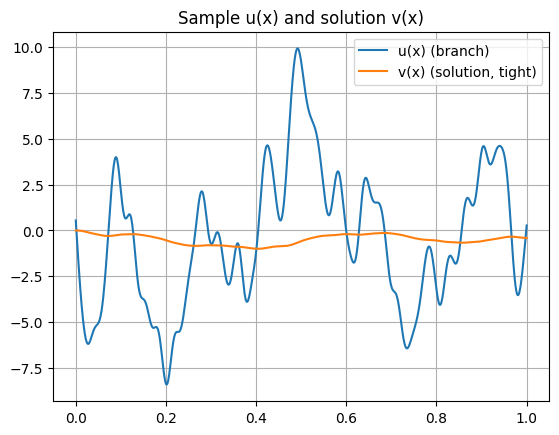

In [69]:

# Quick sanity plots
idx = 10
plt.plot(np.linspace(x_min, x_max, in_size_branch), branch_inputs[idx], label="u(x) (branch)")
plt.plot(trunk_inputs[:, 0], outputs[idx], label="v(x) (solution, tight)")
plt.legend(); plt.grid(); plt.title("Sample u(x) and solution v(x)"); plt.show()


In [70]:
def save_npz_files(branch_inputs, trunk_inputs, outputs, spit: bool,
                   test_fraction: float, train_fname: str, test_fname: str, single_fname: str,
                   val_fraction: Optional[float] = None, val_fname: Optional[str] = None):
    """
    Save DeepONet-aligned .npz files where X is a length-2 object array:
      X[0] = branch_inputs (N_samples, in_size_branch)
      X[1] = trunk_inputs  (N_grid, 1)  -- shared grid
    y has shape (N_samples, N_grid)

    Se spit=True e val_fraction è specificata, salva anche un validation set.
    """
    def pack_X(branch, trunk):
        return np.array([branch, trunk], dtype=object)

    N = branch_inputs.shape[0]
    if spit:
        if val_fraction is None or val_fraction <= 0.0:
            # --- train/test only ---
            N_test = max(1, int(round(N * test_fraction)))
            N_train = N - N_test
            idx = np.arange(N); np.random.shuffle(idx)
            tr_idx, te_idx = idx[:N_train], idx[N_train:]

            X_train = pack_X(branch_inputs[tr_idx], trunk_inputs)
            y_train = outputs[tr_idx]
            X_test  = pack_X(branch_inputs[te_idx],  trunk_inputs)
            y_test  = outputs[te_idx]

            np.savez(train_fname, X=X_train, y=y_train)
            np.savez(test_fname,  X=X_test,  y=y_test)

            print(f"Saved: {train_fname}  train={y_train.shape[0]}")
            print(f"Saved: {test_fname}   test={y_test.shape[0]}")

        else:
            # --- train/val/test split ---
            if val_fname is None:
                raise ValueError("Devi specificare val_fname se usi val_fraction.")

            N_test = max(1, int(round(N * test_fraction)))
            N_val  = max(1, int(round(N * val_fraction)))
            N_train = N - N_test - N_val
            if N_train <= 0:
                raise ValueError("Frazioni troppo grandi: nessun dato per il train.")

            idx = np.arange(N); np.random.shuffle(idx)
            tr_idx = idx[:N_train]
            va_idx = idx[N_train:N_train+N_val]
            te_idx = idx[N_train+N_val:]

            X_train = pack_X(branch_inputs[tr_idx], trunk_inputs)
            y_train = outputs[tr_idx]
            X_val   = pack_X(branch_inputs[va_idx],  trunk_inputs)
            y_val   = outputs[va_idx]
            X_test  = pack_X(branch_inputs[te_idx],  trunk_inputs)
            y_test  = outputs[te_idx]

            np.savez(train_fname, X=X_train, y=y_train)
            np.savez(val_fname,   X=X_val,   y=y_val)
            np.savez(test_fname,  X=X_test,  y=y_test)

            print(f"Saved: {train_fname}  train={y_train.shape[0]}")
            print(f"Saved: {val_fname}    val={y_val.shape[0]}")
            print(f"Saved: {test_fname}   test={y_test.shape[0]}")

    else:
        X = pack_X(branch_inputs, trunk_inputs)
        y = outputs
        np.savez(single_fname, X=X, y=y)
        print(f"Saved: {single_fname} all={y.shape[0]}")

save_npz_files(
    branch_inputs, trunk_inputs, outputs,
    spit, test_fraction, train_fname, test_fname, single_fname,
    val_fraction=val_fraction, val_fname=val_fname
)

Saved: antiderivative_aligned_train.npz  train=1050
Saved: antiderivative_aligned_val.npz    val=150
Saved: antiderivative_aligned_test.npz   test=300


In [71]:
# Ricarica e verifica (ricorda allow_pickle=True in np.load)
if spit:
    tr = np.load(train_fname, allow_pickle=True)
    print("Train shapes:", tr["X"][0].shape, tr["X"][1].shape, tr["y"].shape)

    # Prova a caricare il validation set se specificato e presente
    has_val = False
    if "val_fraction" in globals() and val_fraction and val_fraction > 0 \
       and "val_fname" in globals() and isinstance(val_fname, str) and os.path.exists(val_fname):
        try:
            va = np.load(val_fname, allow_pickle=True)
            print("Val   shapes:", va["X"][0].shape, va["X"][1].shape, va["y"].shape)
            has_val = True
        except Exception as e:
            print(f"[WARN] Impossibile caricare il validation set '{val_fname}': {e}")

    te = np.load(test_fname, allow_pickle=True)
    print("Test  shapes:", te["X"][0].shape, te["X"][1].shape, te["y"].shape)

    # Controllo coerenza della griglia trunk condivisa
    try:
        if not np.array_equal(tr["X"][1], te["X"][1]):
            print("[WARN] La griglia trunk X[1] differisce tra train e test.")
        if has_val and not np.array_equal(tr["X"][1], va["X"][1]):
            print("[WARN] La griglia trunk X[1] differisce tra train e val.")
    except Exception as e:
        print(f"[WARN] Controllo griglia trunk non riuscito: {e}")

else:
    da = np.load(single_fname, allow_pickle=True)
    print("Data shapes:", da["X"][0].shape, da["X"][1].shape, da["y"].shape)


Train shapes: (1050, 1000) (1000, 1) (1050, 1000)
Val   shapes: (150, 1000) (1000, 1) (150, 1000)
Test  shapes: (300, 1000) (1000, 1) (300, 1000)
